In [1]:
from keras.models import load_model
import os
#Load model
model = load_model('anomaly_detection_model.h5')
#關閉gpu
os.environ["CUDA_VISIBLE_DEVICES"]="-1" 

Using TensorFlow backend.
C:\Users\asi\Anaconda3\envs\python36_tf19\lib\site-packages\tensorflow\python\framework\dtypes.py:523: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\asi\Anaconda3\envs\python36_tf19\lib\site-packages\tensorflow\python\framework\dtypes.py:524: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\asi\Anaconda3\envs\python36_tf19\lib\site-packages\tensorflow\python\framework\dtypes.py:525: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\asi\Anaconda3\envs\p

In [2]:
def testing_img(path,output_path,pic_name): 
    
    ####Import 
    import numpy as np
    import pandas as pd
    from matplotlib import pyplot as plt
    %matplotlib inline
    import cv2
    #####
    #resize
    w=299
    h=299
    c=3
    
    columns=['normal', 'abnormal']
    columns_2=['正常', '不正常']
    #tStart = time.time()
    im=path+"/"+pic_name
    pic_time=pic_name.split("-")[1].split(".")[0]
    imgs=[]
    img=cv2.imread(im)
    #顯示圖片
    img_rgb = img[:,:,::-1]
    plt.imshow(img_rgb)
    plt.show()
    #tEnd = time.time()#計時結束
    #print ("讀取圖片完成 共%f 秒" % round((tEnd - tStart),3))
    print ("讀取圖片完成")
    try:
        img_t=cv2.resize(img,(w,h),interpolation=cv2.INTER_CUBIC)
        imgs.append(img_t)
        imgs=np.asarray(imgs,np.float32)
        print ("開始辨識" )
        try:
            predicted=int(np.argmax(model.predict(imgs)[0], axis=0))
            print("目前狀態為: {}".format(columns_2[predicted]))
            if predicted == 1:
                #存圖片到OUTPUT路徑
                cv2.imwrite(output_path+"/{}_{}".format(columns[predicted],pic_name),img)
                print("不正常圖片存檔成功")
            #pic_path=output_path+"/{}_{}".format(columns[predicted],pic_name)
            return [pic_time,predicted,pic_name]
        except:
            print("辨識程序錯誤")
    except:
        print("讀取圖片錯誤")

In [14]:
def job():
    
    ####Import 
    import psycopg2
    import pymysql
    import pymysql.cursors
    import time
    ####
    
    oldpicName = ""
          
    try:
        dirPath = r""
        result = [f for f in os.listdir(dirPath) if os.path.isfile(os.path.join(dirPath, f))]
        #the_2nd_newest=rows[1]
        row=result[1]
        #for row in the_2nd_newest:

        print ("pic_name = ", row)
        pic_name=row
        print ("圖片{}在資料庫中讀取成功".format(pic_name))

        for i in range(5):
            if oldpicName == "" or pic_name != oldpicName:
                print("檔名不重複")
                try:
                    output=testing_img(r"..\raw_pic",
                                       r"..\Notify_abnormal",
                                       pic_name)
                    oldpicName=pic_name
                    print("第1次辨識程序 辨識完成 ")
                    return output

                except:

                    for i in range(4):
                        if i != 3:
                            print("圖片上傳中，五秒重新辨識")
                            time.sleep(5)
                            try:
                                output=testing_img(r"..\raw_pic",
                                                   r"..\Notify_abnormal",
                                                   pic_name)
                                oldpicName=pic_name
                                print("第{}次辨識程序 辨識完成".format(i+2))
                                return output
                            except:
                                print("圖片仍在上傳中")
                        else:
                            print("{} 尚未上傳完成".format(pic_name))
                    break
            else:
                print("檔名重複")
                if i != 4:
                    print("檔案相同")
                    time.sleep(5)
                    continue
                else:
                    print("檔名相同超過五次，請檢查現場圖片是否更新")
    except:
        print("查詢圖片庫失敗")
      
    # 關閉資料庫           
    connection1.close()

In [4]:
#LINE推播
def lineNotifyImage(token, msg, picURI):    
    import requests
    url = "https://notify-api.line.me/api/notify"
    headers = {
        "Authorization": "Bearer " + token
    }
    payload = {'message': msg}
    files = {'imageFile': open(picURI, 'rb')}
    r = requests.post(url, headers=headers, params=payload, files=files)
    return r.status_code

def lineNotifyImage_withproxy(token, msg, picURI):
    import requests
    url = "https://notify-api.line.me/api/notify"
    headers = {
        "Authorization": "Bearer " + token
    } 
    payload = {'message': msg}
    proxies = {
        'http': 'http://localhost:3128',
        'https': 'http://localhost:3128'
    }
    files = {'imageFile': open(picURI, 'rb')}
    r = requests.post(url, headers=headers, params=payload, files=files, proxies=proxies)
    return r.status_code       

In [23]:
def writetopostgresql(outputdata0,outputdata2,outputdata1,status,translatetime):
    ####Import 
    import psycopg2
    ####
    try:
        print("準備寫入資料庫")
        try:
            connection2= psycopg2.connect(database='vibrationbed',
                          user='postgres',
                          password='postgres',
                          host='192.168.11.146',
                          port=5432)
        except (Exception, psycopg2.DatabaseError) as error:
            return(error)
        except:
            print("database 連線 失敗")
        
            print("Unexpected error:",sys.exc_info()[0])
        try:
            cur2= connection2.cursor()
            print("----------------------------------------------------------------------------")
            print ("%s:資料庫連線成功" % time.asctime())
        except:
            print("資料庫連線失敗")

        try:
            #cur2.execute("INSERT INTO vibrationbed (datatime,path,condition,checknotification) VALUES (%s,%s,%s,%s);",(outputdata0,outputdata2,outputdata1, status))
            cur2.callproc('insert_vibrationbeddata', (translatetime,outputdata2,outputdata1, status))
            cur2.close()
            connection2.commit()
            print("Records created successfully")
        except (Exception, psycopg2.DatabaseError) as error:
            print(error)
        except:
            print("Insert 失敗")
            print("Unexpected error:",sys.exc_info()[0])
    except:
        print("寫入資料庫失敗")
    connection2.close() 

In [27]:
def notification():   
    ####Import
    import datetime
    import time
    import sys
    import psycopg2
    import os
    ####
    countfile = open("count.txt", 'r')
    count = int(countfile.read())
    
    output = job()
    print(output)
    
    #outputpath = output[2].replace('/',"\\")
    #print(output[0])
    outputtime = datetime.datetime.strptime(output[0],"%Y%m%d%H%M%S")  
    translateoutputtime=outputtime.strftime('%Y-%m-%d %H:%M:%S')    #string

    newtime=outputtime
        
    if output[1] == 1: 
        if (count == 0):
                try:
                    topostgresql = writetopostgresql(output[0],output[2],str(output[1]),'0',translateoutputtime)
                except:
                    print("SQL Error")

                try:
                    #pass
                    datatimefile = open("datatime.txt", 'w+')

                    if datatimefile.read() == "":
                        datatimefile.write(output[0])
                        countfile = open("count.txt", 'w+')
                        count = count+1
                        countfile.write(str(count))
                        countfile.close()
                        datatimefile.close()
                        print("{}  第一次異常出現 {}".format(output[0],count))
                    else:
                        datatimefile = open("datatime.txt", 'r')
                        oldtimetrans = datatimefile.read()
                        oldtime = datetime.datetime.strptime(oldtimetrans,"%Y%m%d%H%M%S")

                        if ((newtime-oldtime).seconds<40):

                            countfile = open("count.txt", 'w+')
                            count = count+1
                            countfile.write(str(count))
                            countfile.close()   
                            #將新時間寫入txt檔
                            datatimefile = open("datatime.txt", 'w+')
                            datatimefile.write(output[0])
                            datatimefile.close() 
                            print("{}  重新計算第一次異常 {}".format(output[0],count))
                        else:
                            #將新時間寫入txt檔
                            datatimefile = open("datatime.txt", 'w+')
                            datatimefile.write(output[0])
                            datatimefile.close()
                            print("{}  第一次異常出現 {}".format(output[0],count))                            
                except:
                    print("datatime.txt overwrite Error")
                    #print(oldtime)
                    #print(newtime)
        elif count==1:
            
            print("第二次異常出現")
            linecountfile = open("linecount.txt", 'r')
            linecount = int(linecountfile.read())
            print("linecount:{}".format(linecount))
            if (linecount%10 ==0 and linecount<50):
                print("達推播條件 開始Line推播")
                now_str=datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S')
                message = '{} 設備淤積，請盡速處理'.format(now_str)
                #outputpath = output[2].replace('/',"\\")
                picURI= r"C:\Users\asi\Roger\incinerator\Vibrating_bed_model\inference\Notify_abnormal\abnormal_{}".format(output[2])
                #picURI = "{}".format(outputpath)
                # 修改權杖內容
                #內部測試
                #token = 'bREvJKLGcpWzdpydcUdwqzPZhi6ArJyNXggBxzO8GIi'
                #正式
                token = 'ybKjFG57yER5GxdxLed2EzSXbH6WlEJ9sVuLaIHUgbc'
      
                if(lineNotifyImage_withproxy(token, message, picURI)==200):
                    #print("000")
                    topostgresql = writetopostgresql(output[0],output[2],str(output[1]),'1',translateoutputtime)
                    print(topostgresql)

                    # 變數歸零
                    linecountfile = open("linecount.txt", 'w+')
                    linecount = linecount+1
                    linecountfile.write(str(linecount))
                    linecountfile.close() 

                    countfile = open("count.txt", 'w+')
                    count = 0
                    countfile.write(str(count))
                    countfile.close() 

                    print("Line推播成功")

                else:
                    print("Line推播失敗")
            else: 
                print("異常延續 不推播")
                topostgresql = writetopostgresql(output[0],output[2],str(output[1]),'1',translateoutputtime)
                print(topostgresql)

                # 變數歸零
                linecountfile = open("linecount.txt", 'w+')
                linecount = linecount+1
                linecountfile.write(str(linecount))
                linecountfile.close() 

                countfile = open("count.txt", 'w+')
                count = 0
                countfile.write(str(count))
                countfile.close() 
        else:
            print("count 異常")
    else:
        countfile = open("count.txt", 'w+')
        countfile.write(str(0))
        countfile.close()  
        linecountfile = open("linecount.txt", 'w+')
        linecountfile.write(str(0))
        linecountfile.close()
        columns=['正常', '不正常']
        print("{} 狀態為{}  {}".format(output[0],columns[output[1]],count)) 

In [ ]:
from apscheduler.scheduler import Scheduler
countfile = open("count.txt", 'w+')
countfile.write(str(0))
countfile.close()  
linecountfile = open("linecount.txt", 'w+')
linecountfile.write(str(0))
linecountfile.close()  
sched = Scheduler() 
sched.add_interval_job(notification, seconds=30) 
sched.start()

In [26]:
sched.shutdown()

# Test

pic_name =  camera01-20190911104700.jpg


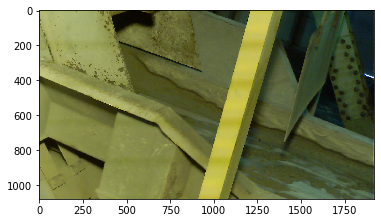

目前狀態為: 正常


In [17]:
import time
from apscheduler.scheduler import Scheduler
import psycopg2
import pymysql
import pymysql.cursors
import cv2
import glob
import os
#關閉gpu
os.environ["CUDA_VISIBLE_DEVICES"]="-1" 
import tensorflow as tf
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
#将所有的图片resize成100*100
w=299
h=299
c=3

connection=pymysql.connect(host='192.168.11.115',
                           port=3306,
                           user='Ac0u5Tasiai',
                           passwd='XY"S/?>wt5K"',
                           db='acoustics')
cur= connection.cursor()
cur.execute("select pic_name from acoustics.t_camera01 order by id desc limit 2")
rows = cur.fetchall()
the_2nd_newest=rows[1]
for row in the_2nd_newest:
    print ("pic_name = ", row)
    pic_name=row
path=r"Y:"
output_path=r"//acs6100P2/Users/asi/Roger/incinerator/Vibrating_bed_model/inference/predict_abnormal"
im=path+"/"+pic_name
imgs=[]
img=cv2.imread(im)
img_rgb = img[:,:,::-1]
plt.imshow(img_rgb)
plt.show()
columns=['normal', 'abnormal']
columns_2=['正常', '不正常']    
img_t=cv2.resize(img,(w,h),interpolation=cv2.INTER_CUBIC)
imgs.append(img_t)
imgs=np.asarray(imgs,np.float32)
predicted=int(np.argmax(model.predict(imgs)[0], axis=0))
print("目前狀態為: {}".format(columns_2[predicted]))
#if predicted == 1:
    #cv2.imwrite(output_path+"/{}_{}_.jpg".format(columns[predicted],pic_name),img) 